In [1]:
import os
import jsonlines
import nltk
import torch
from tqdm import tqdm
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from tw_rouge import get_rouge

dir_path = "/data/NFS/andy/course/ADL/hw3/"
train_path = dir_path + "/data/train.jsonl"
public_path = dir_path + "/data/public.jsonl"
weights_path = dir_path + "/weights/"
model_checkpoint = "google/mt5-small"
nltk.download('punkt')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/home/data/andy/anaconda3/envs/adlhw3/lib/python3.8/site-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:909: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/home/data/andy/anaconda3/envs/adlhw3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
[nltk_data] Downloading package punkt to /home/data/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def load_jsonl(path):
    data = []
    with jsonlines.open(path, "r") as f:
        for row in f:
            data.append(row)
    return data

In [3]:
print("data loading...")
data = load_jsonl(train_path)
public = load_jsonl(public_path)

length = int(len(data)*0.8)
train_data = {"maintext":[], "title":[], "id":[]}
eval_data = {"maintext":[], "title":[], "id":[]}
for sub in data[:length]:
    train_data["maintext"].append(sub["maintext"])
    train_data["title"].append(sub["title"])
    train_data["id"].append(sub["id"])
for sub in data[length:]:
    eval_data["maintext"].append(sub["maintext"])
    eval_data["title"].append(sub["title"])
    eval_data["id"].append(sub["id"])
    
public_data = {"maintext":[], "title":[], "id":[]}
for sub in public:
    public_data["maintext"].append(sub["maintext"])
    public_data["title"].append(sub["title"])
    public_data["id"].append(sub["id"])
    
raw_datasets = DatasetDict({"train":Dataset.from_dict(train_data), "validation":Dataset.from_dict(eval_data)})
public_dataset = Dataset.from_dict(public_data)

data loading...


In [4]:
print("data preprocessing...")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = [doc for doc in examples["maintext"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
public_tokenized_datasets = public_dataset.map(preprocess_function, batched=True)

data preprocessing...


In [5]:
print("model loading...")
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

batch_size = 4
args = Seq2SeqTrainingArguments(
    "test-summarization",
    evaluation_strategy = "epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    gradient_accumulation_steps = 32,
    predict_with_generate =True,
    fp16=True,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = get_rouge(decoded_preds, decoded_labels)
    result = {key: value['f'] * 100 for key, value in result.items()}
    
    return {k: round(v, 4) for k, v in result.items()}

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

model loading...


In [6]:
trainer.train()

In [7]:
trainer.save_model(weights_path)

In [9]:
test_dataloader = trainer.get_test_dataloader(public_tokenized_datasets)

In [10]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
max_target_length = 128
pred_list=[]
label_list=[]

for batch in tqdm(test_dataloader):
    attention_mask = batch['attention_mask'].to(device)
    inputs = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    preds = model.generate(
        input_ids=inputs, 
        attention_mask=attention_mask, 
        max_length=max_target_length,
        early_stopping = True,
        num_beams=2,
        top_k=50,
        top_p=1.0,
        temperature=1.0,
    )
    labels = labels.cpu().numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    for i in range(len(decoded_preds)):
        pred_list.append(decoded_preds[i])
        label_list.append(decoded_labels[i])

  0%|          | 0/1374 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 15.78 GiB total capacity; 1.63 GiB already allocated; 21.00 MiB free; 1.69 GiB reserved in total by PyTorch)

In [ ]:
result = get_rouge(pred_list, label_list)

In [ ]:
result

In [10]:
import matplotlib.pyplot as plt
def plot(rouge_1, rouge_2, rouge_L):
    plt.plot(rouge_1, label='%s' %"rouge-1")
    plt.plot(rouge_2, label="%s" %"rouge-2")
    plt.plot(rouge_L, label="%s" %"rouge-L")
    plt.xlabel('epochs')
    plt.ylabel("val rouge")
    plt.xticks()
    plt.legend(loc='center right')
    plt.show()

In [11]:
rouge_1 = [22.71, 24.08, 25.29, 25.38, 25.95, 25.79, 26.02, 26.38]
rouge_2 = [8.86, 9.63, 10.39, 10.29, 10.53, 10.42, 10.61, 10.83]
rouge_L = [22.06, 23.03, 24.02, 23.82, 24.28, 24.05, 24.33, 24.54]

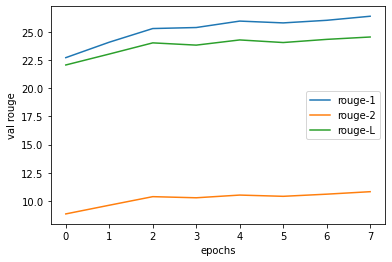

In [12]:
plot(rouge_1, rouge_2, rouge_L)